In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-classification1/spam.tsv


## Here, we will use a csv file containing hundreds of emails already classified as spam and ham(legitimate) message. We will build and train our model and will then use it to predict any real message (outside the csv as well)

In [85]:
# Importing major libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
data=pd.read_table('../input/spam-classification1/spam.tsv', sep='\t')
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [87]:
data.shape

(5572, 4)

In [88]:
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [89]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### we can see there is class imbalance here hence it is better to consider same ham and spam samples. Thus we will randomly take 747 samples of ham and consider for training the model

### Handling classimbalance

In [90]:
ham=data[data['label']=='ham']
ham.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2
6,ham,Even my brother is not like to speak with me. ...,77,2


In [91]:
spam=data[data['label']=='spam']
spam.head()

,label,message,length,punct
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,8
8,spam,WINNER!! As a valued network customer you have...,157,6
9,spam,Had your mobile 11 months or more? U R entitle...,154,2
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,8


In [92]:
# As mentioned earlier, the shape of these 2 datasets is not same, hence let us randomly filter some samples of ham data
ham.shape, spam.shape

((4825, 4), (747, 4))

In [93]:
ham=ham.sample(spam.shape[0])

In [94]:
ham.shape, spam.shape

((747, 4), (747, 4))

Now, both these datasets have same shape and hence there is no class imbalanace problem

In [95]:
# Let's combine the datasets
data_new=ham.append(spam)
data_new.shape

(1494, 4)

In [96]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 3527 to 5567
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1494 non-null   object
 1   message  1494 non-null   object
 2   length   1494 non-null   int64 
 3   punct    1494 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 58.4+ KB


In [97]:
data_new.tail()

,label,message,length,punct
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,158,5
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,8
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,3
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8


## Exploratory data analysis

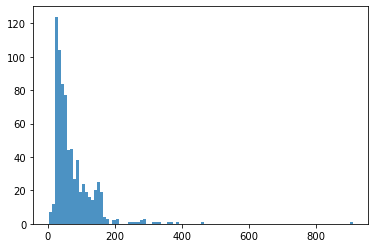

In [98]:
plt.hist(data_new[data_new['label'].astype(str)=='ham']['length'], bins=100, alpha=0.8)
plt.show()

As can be seen, max messages have length less than 100 characters

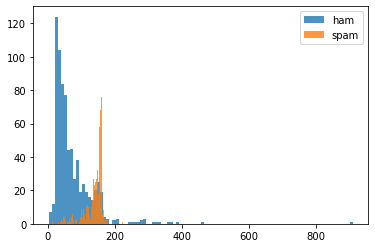

In [99]:
# Let's see both together
plt.hist(data_new[data_new['label'].astype(str)=='ham']['length'], bins=100, alpha=0.8, label='ham')
plt.hist(data_new[data_new['label'].astype(str)=='spam']['length'], bins=100, alpha=0.8, label='spam')
plt.legend(loc='best')
plt.show()

## Data preparation

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
pd.concat([data_new.tail(),data_new.head()])

,label,message,length,punct
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,3
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,158,5
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,8
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,3
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8
3527,ham,HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DEA...,159,10
5181,ham,K sure am in my relatives home. Sms me de. Pls:-),49,5
925,ham,Actually i deleted my old website..now i m blo...,80,4
917,ham,Was actually about to send you a reminder toda...,73,1
2752,ham,Play w computer? Aiyah i tok 2 u lor?,37,2


In [102]:
data_new.shape

(1494, 4)

In [103]:
# Let's do the train test split
X_train, X_test, y_train, y_test = train_test_split(data_new['message'], data_new['label'], test_size=0.3, random_state=1, shuffle=True, stratify=data_new['label'])

In [104]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1045,), (449,), (1045,), (449,))

## Let's create pipeline now of vectorizer and classifier

In [105]:
clf=Pipeline([('vectorizer', TfidfVectorizer()), 
                ('clf', RandomForestClassifier(n_estimators=100) )])


In [106]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [107]:
y_pred=model.predict(X_test)


In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.93      1.00      0.96       224
        spam       1.00      0.92      0.96       225

    accuracy                           0.96       449
   macro avg       0.96      0.96      0.96       449
weighted avg       0.96      0.96      0.96       449



In [109]:
print(confusion_matrix(y_test, y_pred))

[[224   0]
 [ 18 207]]


## Let's check predictions on new dataset

In [111]:
model.predict(["Hey watsapp???"])

array(['ham'], dtype=object)

In [113]:
model.predict(["Congratulations, You have won free ticket to USA this summer, TEXT WON 4555$"])

array(['spam'], dtype=object)

As seen above, it has predicted correctly. Thanks